# Preparation

## Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from transformers import AdamW, get_linear_schedule_with_warmup


from fetchData import fetchdata, cv_events
import __MLP
# from __MLP import getSamplers, convert_df_to_unsqueezed_tensor, train_sequential, clf_report
import random

In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Data

In [4]:
pheme_AVGw2v = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
pheme_sparse = pd.read_csv('./data/_PHEME_sparse.csv')
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
pheme_event = pd.read_csv('./data/_PHEME_text.csv')['Event']
pheme_bert = fetchdata('pheme','bert')
pheme_thread =  fetchdata('pheme','thread')

ext_AVGw2v = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
ext_sparse = pd.read_csv('./data/_PHEMEext_sparse.csv')
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event
ext_bert = fetchdata('ext','bert')
ext_thread = fetchdata('ext','thread')

rhi = pd.read_csv('./data/_RHI_text_AVGw2v.csv').drop(['token'],axis=1)
rhi_y = pd.read_csv('./data/_RHI_target.csv')
rhi_bert = fetchdata('rhi','bert')

In [5]:
# pheme_thread = pheme_thread.replace(-np.inf, 0)
# ext_thread = ext_thread.replace(-np.inf, 0)

In [6]:
cv = cv_events(pd.concat([pheme_sparse, pheme_y, pheme_event],axis=1))
X = cv[3][1].drop(['target', 'Event'],axis=1)
y = cv[3][1].target
val_X = cv[3][0].drop(['target', 'Event'],axis=1)
val_y = cv[3][0].target

## Functions

In [9]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train1(model, num_epochs, criterion, optimizer, train_loader, train_size, test_loader=None, test_size=None, patience=5, PATH='./state_dict_model.pt'):
    set_seed(42)
    train_loss = []
    patience_count = 0
    train_accuracy = []
    prev_loss = 10
    best_loss = 10.0
    val_corrects_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        running_corrects = 0.0
        running_loss = 0.0
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.float(), labels.float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            #  _, predictions = torch.max(outputs.data, 1) won’t work if your output only contains a single output unit.
            # _, preds = torch.max(outputs, 1)
            # print(outputs.flatten().size())
            preds = outputs.squeeze(1) > 0.0

            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            # step function
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        # print(running_loss)
        # print(train_size)
        epoch_acc = running_corrects.double() / train_size
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        if (epoch % 2 == 0):
            print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch,
                                                                         num_epochs - 1, epoch_acc, epoch_loss))

        if (test_loader != None):
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_corrects = 0
                val_preds_list = []
                val_label_list = []
                for j, val in enumerate(test_loader, 0):
                    val_x, val_label = val
                    val_x, val_label = val_x.float(), val_label.float()
                    val_outputs = model(val_x)
                    # _, val_preds = torch.max(val_outputs, 1)
                    val_preds = val_outputs.squeeze(1) > 0.0

                    val_preds_list.append(val_preds)
                    val_label_list.append(val_label)
                    v_loss = criterion(val_outputs, val_label.unsqueeze(1))
                    val_loss += (v_loss.item() * val_x.size(0))
                    val_corrects += torch.sum(val_preds == val_label)
                    # accuracy = (preds == b_labels).cpu().numpy().mean() * 100

                if (epoch % 2 == 0):
                    val_preds_list = torch.cat(val_preds_list, 0)
                    val_label_list = torch.cat(val_label_list, 0)
                    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))
                    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
                        val_corrects/test_size, val_loss/test_size))
            val_corrects_list.append(val_corrects/test_size)
            val_loss_list.append(val_loss/test_size)
            val_acc = val_corrects.double() / test_size
            val_acc_list.append(val_acc)

        if epoch_loss < best_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print(
                "\t\tSaving the best model w/ loss {:.4f}".format(epoch_loss))
            torch.save(model.state_dict(), PATH)
            best_loss = epoch_loss
            patience_count = 0
        elif best_loss < epoch_loss:
            patience_count += 1
        if patience_count >= patience:
            print("Finishing the Model: Loss is not decreasing...")
            print(train_loss[-6:-1])
            return train_accuracy, train_loss, val_acc_list, val_loss_list
    return train_accuracy, train_loss, val_acc_list, val_loss_list

def train2(model, num_epochs, criterion, optimizer, train_loader, train_size, test_loader=None, test_size=None, patience=5, PATH='./state_dict_model.pt'):
    set_seed(42)
    train_loss = []
    patience_count = 0
    train_accuracy = []
    prev_loss = 10
    best_loss = 10.0
    val_corrects_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        running_corrects = 0.0
        running_loss = 0.0
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.float(), labels.float()
            print(inputs.size())
            print(labels.size())
            print(inputs.flatten())
            print(labels.flatten())

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            print("outputs:",outputs.size())
            print("outputs:",outputs)
            print("labels:",labels.size())
            print("labels:",labels.unsqueeze(1).size())

            #  _, predictions = torch.max(outputs.data, 1) won’t work if your output only contains a single output unit.
            # _, preds = torch.max(outputs, 1)
            preds = torch.argmax(outputs, dim=1).flatten()
            # print(outputs.flatten().size())
            # preds = outputs > 0.0
            # labels = labels.view(-1)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            # step function
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            # print('running correct')
            # print(running_corrects)

        epoch_loss = running_loss / train_size
        # print(running_loss)
        # print(train_size)
        epoch_acc = running_corrects.double() / train_size
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        if (epoch % 2 == 0):
            print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch,
                                                                         num_epochs - 1, epoch_acc, epoch_loss))

        if (test_loader != None):
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_corrects = 0
                val_preds_list = []
                val_label_list = []
                for j, val in enumerate(test_loader, 0):
                    val_x, val_label = val
                    val_x, val_label = val_x.float(), val_label.float()
                    val_outputs = model(val_x)
                    val_preds = torch.argmax(val_outputs, dim=1).flatten()
                    # _, val_preds = torch.max(val_outputs, 1)
                    # print("val_outputs:",val_outputs.flatten())
                    # val_preds = val_outputs > 0.0
                    # print("val_preds:",val_preds)
                    val_preds_list.append(val_preds)
                    val_label_list.append(val_label)
                    v_loss = criterion(val_outputs, val_label.unsqueeze(1))
                    val_loss += (v_loss.item() * val_x.size(0))
                    val_corrects += torch.sum(val_preds ==
                                              val_label.data).double()
                if (epoch % 2 == 0):
                    val_preds_list = torch.cat(val_preds_list, 0)
                    val_label_list = torch.cat(val_label_list, 0)
                    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))
                    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
                        val_corrects/test_size, val_loss/test_size))
            val_corrects_list.append(val_corrects/test_size)
            val_loss_list.append(val_loss/test_size)
            val_acc = val_corrects.double() / test_size
            val_acc_list.append(val_acc)

        if epoch_loss < best_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print(
                "\t\tSaving the best model w/ loss {:.4f}".format(epoch_loss))
            torch.save(model.state_dict(), PATH)
            best_loss = epoch_loss
            patience_count = 0
        elif best_loss < epoch_loss:
            patience_count += 1
        if patience_count >= patience:
            print("Finishing the Model: Loss is not decreasing...")
            print(train_loss[-6:-1])
            return train_accuracy, train_loss, val_acc_list, val_loss_list
    return train_accuracy, train_loss, val_acc_list, val_loss_list

def predict(model, criterion, val_dataloader, val_size):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        for j, val in enumerate(val_dataloader, 0):
            val_x, val_label = val
            val_x, val_label = val_x.float(), val_label.float()
            val_outputs = model(val_x)
            val_preds = val_outputs.squeeze(1) > 0.0

            val_preds_list.append(val_preds)
            val_label_list.append(val_label)
            v_loss = criterion(val_outputs, val_label.unsqueeze(1))
            val_loss += (v_loss.item() * val_x.size(0))
            val_corrects += torch.sum(val_preds == val_label)

    val_preds_list = torch.cat(val_preds_list, 0)
    val_label_list = torch.cat(val_label_list, 0)
    val_corrects = val_corrects/val_size
    val_loss/test_size
    val_acc = val_corrects.double() / val_size
    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
        val_corrects/val_size, val_loss/test_size))
    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/val_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))


# Sparse-MLP

In [6]:
# train, test = __MLP.scaleData(pheme_sparse.values,ext_sparse.values)
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_sparse,pheme_y,ext_sparse,ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)
print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())

torch.Size([5802, 1, 29]) torch.Size([485, 1, 29])
torch.Size([5802, 1]) torch.Size([485, 1])


In [8]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(81.0324), std: tensor(373.0824)
torch.Size([5802, 1, 29]) torch.Size([485, 1, 29])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [10]:
class sparse_model(nn.Module):
    def __init__(self):
        super(sparse_model, self).__init__() # 1*20
        self.fc1 = nn.Linear(29, 12, bias=True) # 420
        self.fc2 = nn.Linear(12, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
model_sparse = sparse_model()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model_sparse.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model_sparse.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_sparse_model.pt"

In [13]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_sparse, num_epochs=40, patience=10, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/39	Train) Acc: 0.4897, Loss: 6.6408
		Validation) Acc: 0.7505 Loss:0.7176
		Saving the best model w/ loss 6.6408
		Saving the best model w/ loss 2.9049
Epoch 2/39	Train) Acc: 0.4966, Loss: 2.2544
		Validation) Acc: 0.4454 Loss:0.7810
		Saving the best model w/ loss 2.2544
		Saving the best model w/ loss 1.9121
Epoch 4/39	Train) Acc: 0.5102, Loss: 1.6465
		Validation) Acc: 0.5113 Loss:0.7235
		Saving the best model w/ loss 1.6465
		Saving the best model w/ loss 1.5426
Epoch 6/39	Train) Acc: 0.4991, Loss: 1.4276
		Validation) Acc: 0.4165 Loss:0.7592
		Saving the best model w/ loss 1.4276
Epoch 8/39	Train) Acc: 0.4974, Loss: 1.1700
		Validation) Acc: 0.4062 Loss:0.7533
		Saving the best model w/ loss 1.1700
		Saving the best model w/ loss 1.0617
Epoch 10/39	Train) Acc: 0.4993, Loss: 1.0730
		Validation) Acc: 0.3649 Loss:0.7775
		Saving the best model w/ loss 0.9574
Epoch 12/39	Train) Acc: 0.4972, Loss: 0.9224
		Validation) Acc: 0.3959 Loss:0.7448
		Saving the best model w/ loss 0.

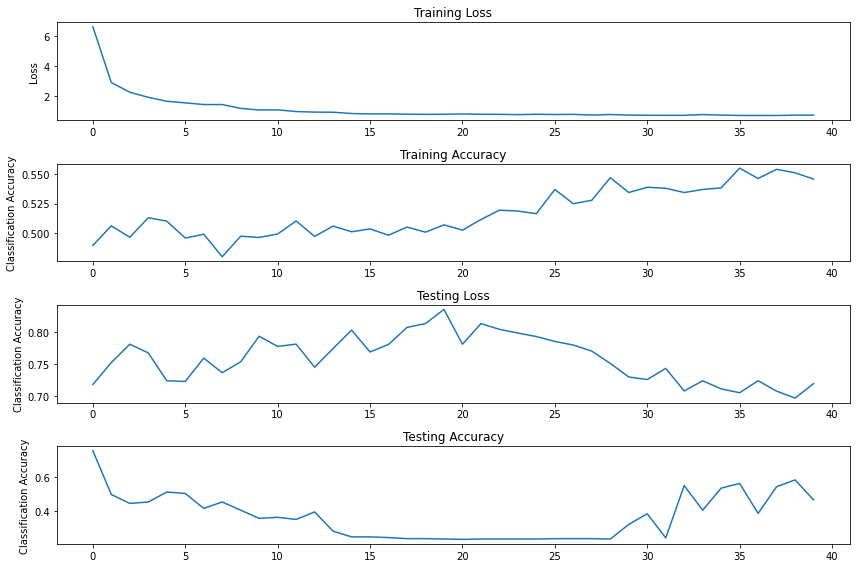

Min of Training Loss: 0.695658
Max of Training Accuracy: 0.555153
Mean of Training Loss: 1.133345
Mean of Training Accuracy: 0.517343
----
Max of Testing Accuracy: 0.750515
Mean of Testing Loss: 0.758975
Mean of Testing Accuracy: 0.370103


In [15]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

# W2V-MLP

In [7]:
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_AVGw2v,pheme_y,ext_AVGw2v,ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)
print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())

torch.Size([5802, 1, 200]) torch.Size([485, 1, 200])
torch.Size([5802, 1]) torch.Size([485, 1])


In [8]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape)
print(tensor_y1.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(-0.0126), std: tensor(0.2787)
torch.Size([5802, 1, 200])
torch.Size([5802, 1])
Train Size 5802 Test Size 485


In [52]:
class W2V_net(nn.Module):
    def __init__(self):
        super(W2V_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(200, 32, bias=True) # 420
        self.fc2 = nn.Linear(32, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [55]:
model_w2v = W2V_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(task1_model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_w2v.parameters(), lr=1e-5, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

train_loss = []
train_accuracy = []

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_w2v_model.pt"

In [58]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_w2v, num_epochs=40, patience=15, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/39	Train) Acc: 0.4943, Loss: 0.6992
		Validation) Acc: 0.7608 Loss:0.6523
		Saving the best model w/ loss 0.6992
		Saving the best model w/ loss 0.6961
Epoch 2/39	Train) Acc: 0.5029, Loss: 0.6913
		Validation) Acc: 0.7608 Loss:0.6578
		Saving the best model w/ loss 0.6913
		Saving the best model w/ loss 0.6877
Epoch 4/39	Train) Acc: 0.5483, Loss: 0.6837
		Validation) Acc: 0.7794 Loss:0.6639
		Saving the best model w/ loss 0.6837
		Saving the best model w/ loss 0.6789
Epoch 6/39	Train) Acc: 0.6350, Loss: 0.6718
		Validation) Acc: 0.7753 Loss:0.6670
		Saving the best model w/ loss 0.6718
		Saving the best model w/ loss 0.6660
Epoch 8/39	Train) Acc: 0.6749, Loss: 0.6619
		Validation) Acc: 0.6887 Loss:0.6694
		Saving the best model w/ loss 0.6619
		Saving the best model w/ loss 0.6559
Epoch 10/39	Train) Acc: 0.6986, Loss: 0.6493
		Validation) Acc: 0.6680 Loss:0.6688
		Saving the best model w/ loss 0.6493
		Saving the best model w/ loss 0.6430
Epoch 12/39	Train) Acc: 0.7125, Loss: 0

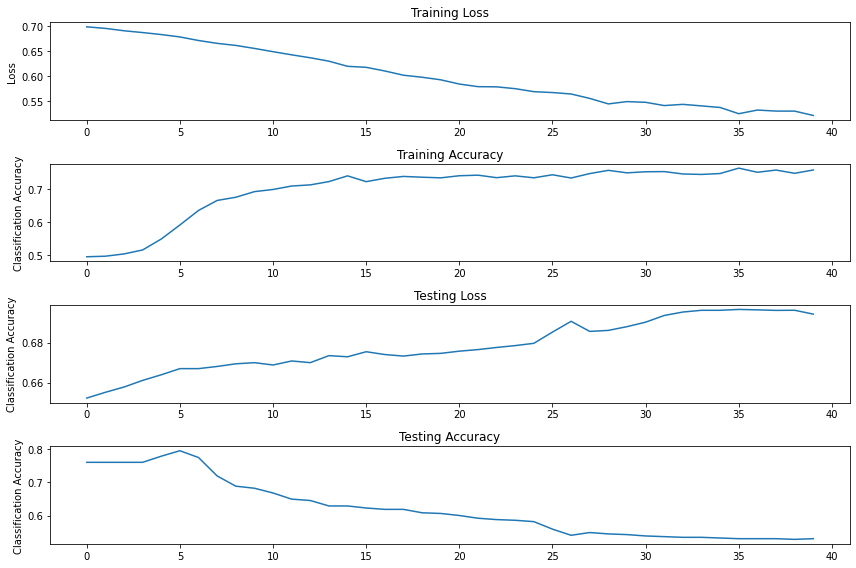

Min of Training Loss: 0.521443
Max of Training Accuracy: 0.763357
Mean of Training Loss: 0.600312
Mean of Training Accuracy: 0.699961
----
Max of Testing Accuracy: 0.795876
Mean of Testing Loss: 0.678386
Mean of Testing Accuracy: 0.619536


In [59]:
clf_report(train_loss, train_acc, val_loss_list, val_acc)

# BERT - MLP

In [10]:
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_bert, pheme_y, ext_bert, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)
print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())

batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape)
print(tensor_y1.shape)
print("Train Size",train_size,"Test Size",test_size)

torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
mean: tensor(0.0439), std: tensor(0.3089)
torch.Size([5802, 1, 768])
torch.Size([5802, 1])
Train Size 5802 Test Size 485


In [11]:
class BERT_net(nn.Module):
    def __init__(self):
        super(BERT_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(768, 50, bias=True) # 420
        self.fc2 = nn.Linear(50, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [13]:
model_bert = BERT_net()
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_bert.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

epochs = 40

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_bert_model.pt"

In [14]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bert, num_epochs=40, patience=15, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/39	Train) Acc: 0.6898, Loss: 0.6063
		Validation) Acc: 0.6515 Loss:0.7105
		Saving the best model w/ loss 0.6063
		Saving the best model w/ loss 0.5621
Epoch 2/39	Train) Acc: 0.7149, Loss: 0.5546
		Validation) Acc: 0.6557 Loss:0.8388
		Saving the best model w/ loss 0.5546
		Saving the best model w/ loss 0.5334
Epoch 4/39	Train) Acc: 0.7304, Loss: 0.5323
		Validation) Acc: 0.6144 Loss:0.9224
		Saving the best model w/ loss 0.5323
		Saving the best model w/ loss 0.5239
Epoch 6/39	Train) Acc: 0.7611, Loss: 0.5137
		Validation) Acc: 0.6082 Loss:0.9203
		Saving the best model w/ loss 0.5137
		Saving the best model w/ loss 0.5109
Epoch 8/39	Train) Acc: 0.7544, Loss: 0.5141
		Validation) Acc: 0.6000 Loss:0.9363
		Saving the best model w/ loss 0.4991
Epoch 10/39	Train) Acc: 0.7661, Loss: 0.5075
		Validation) Acc: 0.5753 Loss:0.9536
		Saving the best model w/ loss 0.4988
Epoch 12/39	Train) Acc: 0.7682, Loss: 0.4985
		Validation) Acc: 0.5649 Loss:0.9704
		Saving the best model w/ loss 0.

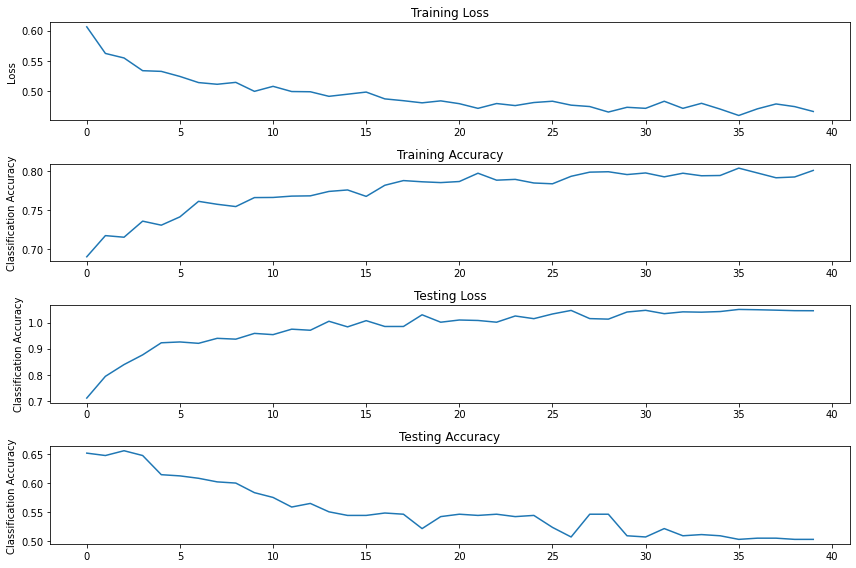

Min of Training Loss: 0.459100
Max of Training Accuracy: 0.803861
Mean of Training Loss: 0.493687
Mean of Training Accuracy: 0.775185
----
Max of Testing Accuracy: 0.655670
Mean of Testing Loss: 0.984076
Mean of Testing Accuracy: 0.553866


In [16]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

# Thread

In [7]:
# train, test = __MLP.scaleData(pheme_sparse.values,ext_sparse.values)
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_thread,pheme_y,ext_thread,ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)
print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())

torch.Size([5802, 1, 36]) torch.Size([485, 1, 36])
torch.Size([5802, 1]) torch.Size([485, 1])


In [8]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(1704.3844), std: tensor(26082.9453)
torch.Size([5802, 1, 36]) torch.Size([485, 1, 36])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [9]:
class thread_model(nn.Module):
    def __init__(self):
        super(thread_model, self).__init__() # 1*20
        self.fc1 = nn.Linear(36, 8, bias=True) # 420
        # self.fc2 = nn.Linear(12, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        # x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
model_thread = thread_model()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model_sparse.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model_sparse.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_sparse_model.pt"

In [17]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_thread, num_epochs=100, patience=30, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.4945, Loss: 623.6534
		Validation) Acc: 0.7608 Loss:167.8163


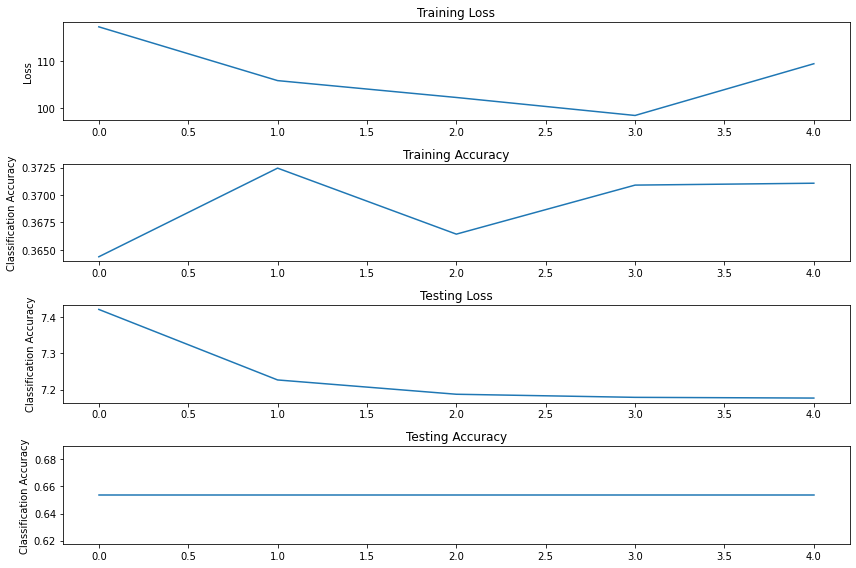

In [ ]:
clf_report(train_loss, train_acc, val_loss_list, val_acc)

# Sparse + W2V -> MLP

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pheme_sparse = scaler.fit_transform(pheme_sparse.values)
sparse_bert = np.concatenate([pheme_sparse, pheme_bert.values],axis=1)
ext_sparse = scaler.fit_transform(ext_sparse.values)
sparse_bert_ext = np.concatenate([ext_sparse, ext_bert.values],axis=1)

tensor_x1 = torch.Tensor(sparse_bert).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(sparse_bert_ext).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [57]:
pheme_sparse_W2V = pd.concat([pheme_sparse, pheme_AVGw2v],axis=1)
ext_sparse_W2V = pd.concat([ext_sparse, ext_AVGw2v],axis=1)

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_sparse_W2V, pheme_y, ext_sparse_W2V, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)
print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())

torch.Size([5802, 1, 229]) torch.Size([485, 1, 229])
torch.Size([5802, 1]) torch.Size([485, 1])


In [59]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(10.0300), std: tensor(133.5756)
torch.Size([5802, 1, 229]) torch.Size([485, 1, 229])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [60]:
class W2V_sparse_net(nn.Module):
    def __init__(self):
        super(W2V_sparse_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(229, 50, bias=True) # 420
        self.fc2 = nn.Linear(50, 8, bias=True)
        self.fc3 = nn.Linear(8, 1,bias=True)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [61]:
set_seed(42)
model_w2vsparse = W2V_sparse_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_w2vsparse.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_w2v_sparse_model.pt"

In [63]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_w2vsparse, num_epochs=40, patience=8, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/39	Train) Acc: 0.4964, Loss: 1.1619
		Validation) Acc: 0.4103 Loss:0.8039
		Saving the best model w/ loss 1.1619
		Saving the best model w/ loss 0.8770
Epoch 2/39	Train) Acc: 0.4883, Loss: 0.9466
		Validation) Acc: 0.7443 Loss:0.7230
		Saving the best model w/ loss 0.8220
Epoch 4/39	Train) Acc: 0.4831, Loss: 0.8286
		Validation) Acc: 0.7505 Loss:0.7036
		Saving the best model w/ loss 0.7546
Epoch 6/39	Train) Acc: 0.5019, Loss: 0.8223
		Validation) Acc: 0.7526 Loss:0.7055
Epoch 8/39	Train) Acc: 0.5009, Loss: 0.8449
		Validation) Acc: 0.7526 Loss:0.6902
		Saving the best model w/ loss 0.7223
Epoch 10/39	Train) Acc: 0.5160, Loss: 0.7300
		Validation) Acc: 0.7546 Loss:0.6764
Epoch 12/39	Train) Acc: 0.4995, Loss: 0.7305
		Validation) Acc: 0.7546 Loss:0.6784
		Saving the best model w/ loss 0.7204
Epoch 14/39	Train) Acc: 0.5093, Loss: 0.7425
		Validation) Acc: 0.7546 Loss:0.6702
		Saving the best model w/ loss 0.7117
Epoch 16/39	Train) Acc: 0.5050, Loss: 0.7084
		Validation) Acc: 0.75

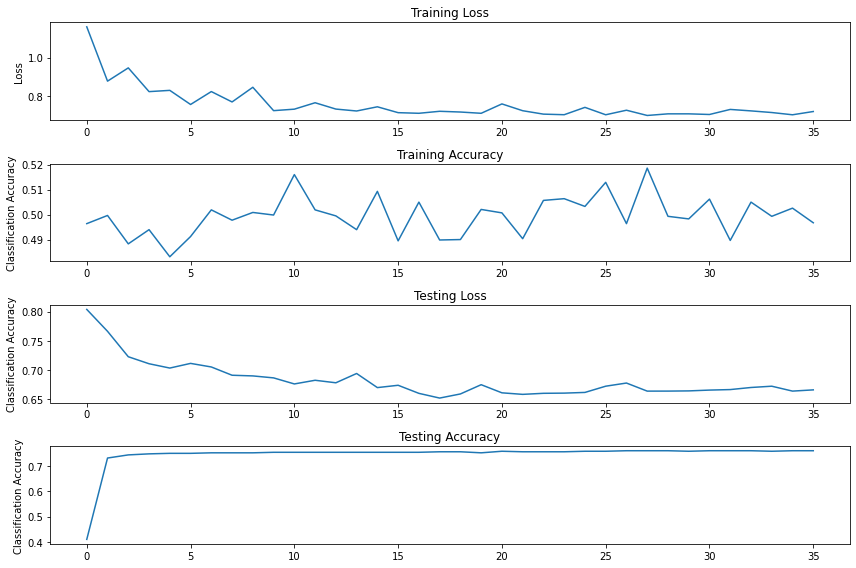

Min of Training Loss: 0.696975
Max of Training Accuracy: 0.518614
Mean of Training Loss: 0.756582
Mean of Training Accuracy: 0.499483
----
Max of Testing Accuracy: 0.760825
Mean of Testing Loss: 0.682468
Mean of Testing Accuracy: 0.745762


In [65]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

# Sparse + BERT -> MLP

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pheme_sparse = scaler.fit_transform(pheme_sparse.values)
sparse_bert = np.concatenate([pheme_sparse, pheme_bert.values],axis=1)
ext_sparse = scaler.fit_transform(ext_sparse.values)
sparse_bert_ext = np.concatenate([ext_sparse, ext_bert.values],axis=1)

In [14]:
# Train = pd.concat([pheme_bert, pheme_sparse], axis=1)
# Test = pd.concat([ext_bert, ext_sparse], axis=1)

tensor_x1 = torch.Tensor(sparse_bert).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(sparse_bert_ext).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [66]:
pheme_sparse_bert = pd.concat([pheme_sparse, pheme_bert],axis=1)
ext_sparse_bert = pd.concat([ext_sparse, ext_bert],axis=1)

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_sparse_bert, pheme_y, ext_sparse_bert, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)
print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())

torch.Size([5802, 1, 797]) torch.Size([485, 1, 797])
torch.Size([5802, 1]) torch.Size([485, 1])


In [67]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(2.8082), std: tensor(69.8108)
torch.Size([5802, 1, 797]) torch.Size([485, 1, 797])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [70]:
class BERT_sparse_net(nn.Module):
    def __init__(self):
        super(BERT_sparse_net, self).__init__()  # 1*20
        self.fc1 = nn.Linear(797, 64, bias=True)  # 420
        self.fc2 = nn.Linear(64, 8, bias=True)
        self.fc3 = nn.Linear(8, 1, bias=True)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_1 = nn.Dropout(0.1)
        self.drop_2 = nn.Dropout(0.2)
        self.batchnorm = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x


In [73]:
set_seed(42)
model_bertsparse = BERT_sparse_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_bertsparse.parameters(), lr=5e-5,eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

epochs = 40

PATH = "./Model/state_dict_bert_sparse_model.pt"

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

In [74]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bertsparse, num_epochs=40, patience=10, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/39	Train) Acc: 0.5165, Loss: 2.5900
		Validation) Acc: 0.2536 Loss:0.9366
		Saving the best model w/ loss 2.5900
		Saving the best model w/ loss 1.0442
Epoch 2/39	Train) Acc: 0.5453, Loss: 0.9266
		Validation) Acc: 0.2330 Loss:0.9502
		Saving the best model w/ loss 0.9266
		Saving the best model w/ loss 0.9123
Epoch 4/39	Train) Acc: 0.5393, Loss: 0.7625
		Validation) Acc: 0.2495 Loss:0.9336
		Saving the best model w/ loss 0.7625
		Saving the best model w/ loss 0.7549
Epoch 6/39	Train) Acc: 0.5836, Loss: 0.7425
		Validation) Acc: 0.4144 Loss:0.8311
		Saving the best model w/ loss 0.7425
Epoch 8/39	Train) Acc: 0.6051, Loss: 0.7172
		Validation) Acc: 0.6433 Loss:0.8498
		Saving the best model w/ loss 0.7172
		Saving the best model w/ loss 0.6527
Epoch 10/39	Train) Acc: 0.6348, Loss: 0.6409
		Validation) Acc: 0.6412 Loss:0.9063
		Saving the best model w/ loss 0.6409
		Saving the best model w/ loss 0.6321
Epoch 12/39	Train) Acc: 0.6450, Loss: 0.6339
		Validation) Acc: 0.6412 Loss:0.

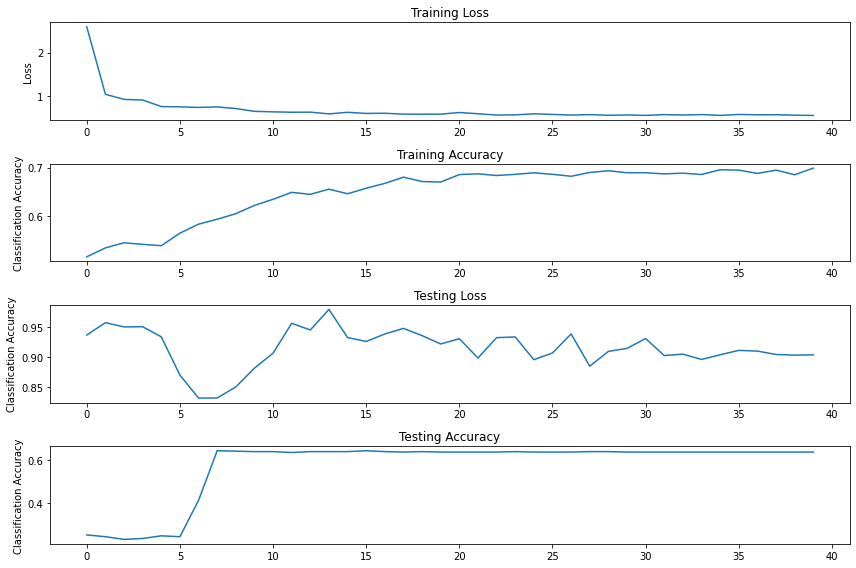

Min of Training Loss: 0.558032
Max of Training Accuracy: 0.698897
Mean of Training Loss: 0.687022
Mean of Training Accuracy: 0.650168
----
Max of Testing Accuracy: 0.645361
Mean of Testing Loss: 0.914780
Mean of Testing Accuracy: 0.575155


In [76]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

# Sparse + BERT -> MLP (2)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

pheme_scaled = scaler.fit_transform(np.concatenate([pheme_sparse.values, pheme_thread.values],axis=1))
# Train = np.concatenate([train, pheme_bert.values],axis=1)

ext_sparse_scaled = scaler.transform(np.concatenate([ext_sparse.values, ext_thread.values],axis=1))
# Test = np.concatenate([test, ext_bert.values],axis=1)

In [10]:
# tensor_x11 = torch.Tensor(pheme_scaled).unsqueeze(1)
tensor_x11 = torch.Tensor(pheme_sparse.values).unsqueeze(1)
tensor_x12 = torch.Tensor(pheme_bert.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x11, tensor_x12, tensor_y1)

tensor_x21 = torch.Tensor(ext_sparse.values).unsqueeze(1)
# tensor_x21 = torch.Tensor(ext_sparse_scaled).unsqueeze(1)
tensor_x22 = torch.Tensor(ext_bert.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x21, tensor_x22, tensor_y2)


In [5]:
tensor_x11, tensor_x12, tensor_y1, tensor_x21, tensor_x22, tensor_y2 = convert_df_to_unsqueezed_tensor(pheme_sparse, pheme_y, ext_sparse, ext_y, pheme_bert, ext_bert)
train_dataset = TensorDataset(tensor_x11, tensor_x12, tensor_y1)
test_dataset = TensorDataset(tensor_x21, tensor_x22, tensor_y2)

In [4]:
import __MLP

In [11]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x21)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x11.shape,tensor_x21.shape)
print(tensor_x12.shape,tensor_x22.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(89.6314), std: tensor(419.5555)
torch.Size([5802, 1, 29]) torch.Size([485, 1, 29])
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [12]:
class BERT_sparse_net_multi(nn.Module):
    def __init__(self):
        super(BERT_sparse_net_multi, self).__init__()  # 1*20


        self.layer1 = nn.Sequential(
            nn.Linear(29, 5, bias=True),  # 420
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(5, 2, bias=True),  # 420
        )
        self.layer2 = nn.Sequential(
            nn.Linear(768, 64, bias=True),  # 420
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 8, bias=True),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Linear(10, 1)  # 420
        )

        self.drop_2 = nn.Dropout(0.2)

    def forward(self, sparse, embedding):
        x1 = self.layer1(sparse)
        x2 = self.layer2(embedding)
        
        x = torch.cat((x1.squeeze(1), x2.squeeze(1)), dim=1)
        x = self.layer3(x)
        return x

In [16]:
# _MLP.set_seed(42)
model_bertsparse_multi = BERT_sparse_net_multi()
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_bertsparse_multi.parameters(), lr=5e-5,eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

epochs = 40

PATH = "./Model/state_dict_temp.pt"

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

NameError: name 'train_dataloader' is not defined

In [42]:
def predict(model, criterion, val_dataloader, val_size):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        for j, val in enumerate(val_dataloader, 0):
            val_sparse, val_embedding, val_labels = val
            val_sparse, val_embedding, val_labels = val_sparse.float(), val_embedding.float(), val_labels.float().squeeze(1)
            val_outputs = model(val_sparse, val_embedding)
            val_preds = val_outputs.squeeze(1) > 0.0

            val_preds_list.append(val_preds)
            val_label_list.append(val_labels)
            v_loss = criterion(val_outputs, val_labels.unsqueeze(1))
            val_loss += (v_loss.item() * val_labels.size(0))
            val_corrects += torch.sum(val_preds == val_labels)

    val_preds_list = torch.cat(val_preds_list, 0)
    val_label_list = torch.cat(val_label_list, 0)
    val_corrects = val_corrects/val_size
    val_loss = val_loss/val_size
    val_acc = val_corrects.double() / val_size
    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
        val_corrects/val_size, val_loss/val_size))
    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/val_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train3(model, num_epochs, criterion, optimizer,scheduler, train_loader, train_size, test_loader=None, test_size=None, patience=5, PATH='./state_dict_model.pt'):
    set_seed(42)
    train_loss = []
    patience_count = 0
    train_accuracy = []
    prev_loss = 10
    best_loss = 10.0
    val_corrects_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        running_corrects = 0.0
        running_loss = 0.0
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            sparse, embedding, labels = data
            sparse, embedding, labels = sparse.float(), embedding.float(), labels.float().squeeze(1)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(sparse, embedding)

            #  _, predictions = torch.max(outputs.data, 1) won’t work if your output only contains a single output unit.
            # _, preds = torch.max(outputs, 1)
            # print(outputs.flatten().size())
            preds = outputs.squeeze(1) > 0.0

            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            # step function
            scheduler.step()

            running_loss += loss.item() * sparse.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        # print(running_loss)
        # print(train_size)
        epoch_acc = running_corrects.double() / train_size
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        if (epoch % 2 == 0):
            print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch,
                                                                         num_epochs - 1, epoch_acc, epoch_loss))

        if (test_loader != None):
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_corrects = 0
                val_preds_list = []
                val_label_list = []
                for j, val in enumerate(test_loader, 0):
                    val_sparse, val_embedding, val_labels = data
                    val_sparse, val_embedding, val_labels = val_sparse.float(), val_embedding.float(), val_labels.float().squeeze(1)
                    val_outputs = model(val_sparse, val_embedding)
                    # _, val_preds = torch.max(val_outputs, 1)
                    # print("val_outputs size:",val_outputs.size())
                    # print("val_label size:",val_label.size())
                    val_preds = val_outputs.squeeze(1) > 0.0
                    # print("pred size:",val_preds.size())

                    # print("Length of val_preds:",val_preds.size())
                    val_preds_list.append(val_preds)
                    val_label_list.append(val_labels)
                    v_loss = criterion(val_outputs, val_labels.unsqueeze(1))
                    val_loss += (v_loss.item() * val_labels.size(0))
                    val_corrects += torch.sum(val_preds == val_labels)
                    # print("== length",val_preds == val_label)
                    # accuracy = (preds == b_labels).cpu().numpy().mean() * 100

                    # print("val_corrects:",val_corrects)
                # print("length of one batch")
                # print("FINAL val_corrects:",val_corrects)
                # print("test_size:",test_size)
                    
                if (epoch % 2 == 0):
                    val_preds_list = torch.cat(val_preds_list, 0)
                    val_label_list = torch.cat(val_label_list, 0)
                    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))
                    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
                        val_corrects/test_size, val_loss/test_size))
            val_corrects_list.append(val_corrects/test_size)
            val_loss_list.append(val_loss/test_size)
            val_acc = val_corrects.double() / test_size
            val_acc_list.append(val_acc)

        if epoch_loss < best_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print(
                "\t\tSaving the best model w/ loss {:.4f}".format(epoch_loss))
            torch.save(model.state_dict(), PATH)
            best_loss = epoch_loss
            patience_count = 0
        elif best_loss < epoch_loss:
            patience_count += 1
        if patience_count >= patience:
            print("Finishing the Model: Loss is not decreasing...")
            print(train_loss[-6:-1])
            return train_accuracy, train_loss, val_acc_list, val_loss_list
    return train_accuracy, train_loss, val_acc_list, val_loss_list

In [7]:
train_acc, train_loss, val_acc, val_loss_list = train3(patience=10,model=model_bertsparse_multi, num_epochs=epochs, criterion=criterion, optimizer=optimizer,scheduler=scheduler, train_loader=train_dataloader, train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)

NameError: name 'train3' is not defined

In [4]:
import __MLP

In [6]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

NameError: name 'train_loss' is not defined

In [300]:
predict(model_bertsparse, criterion, test_dataloader, test_size)

ValueError: too many values to unpack (expected 2)

## Previous Models

self.layer1 = nn.Sequential(
    nn.Linear(768, 64, bias=True),  # 420
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 8, bias=True),
    nn.ReLU()
)

self.layer2 = nn.Sequential(
    nn.Linear(27, 5, bias=True),  # 420
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(5, 2, bias=True),
    nn.ReLU()
)

self.layer3 = nn.Sequential(
    nn.Linear(10, 1)  # 420
)

Min of Training Loss: 0.471854
Max of Training Accuracy: 0.785764
Mean of Training Loss: 0.505716
Mean of Training Accuracy: 0.758512
----
Max of Testing Accuracy: 0.639175
Mean of Testing Loss: 0.351359
Mean of Testing Accuracy: 0.454525

self.layer1 = nn.Sequential(
    nn.Linear(768, 64, bias=True),  # 420
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 5, bias=True),
    nn.ReLU()
)

self.layer2 = nn.Sequential(
    nn.Linear(27, 5, bias=True),  # 420
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(5, 2, bias=True),
    nn.ReLU()
)

self.layer3 = nn.Sequential(
    nn.Linear(7, 1)  # 420
)

Min of Training Loss: 0.467921
Max of Training Accuracy: 0.788694
Mean of Training Loss: 0.501997
Mean of Training Accuracy: 0.760402
----
Max of Testing Accuracy: 0.639175
Mean of Testing Loss: 0.348198
Mean of Testing Accuracy: 0.459259

# BERT + SPARSE + THREAD

In [69]:
pheme_scaled = scaler.fit_transform(np.concatenate([pheme_sparse.values, pheme_thread.values],axis=1))
# Train = np.concatenate([train, pheme_bert.values],axis=1)

ext_sparse_scaled = scaler.fit_transform(np.concatenate([ext_sparse.values, ext_thread.values],axis=1))
# Test = np.concatenate([test, ext_bert.values],axis=1)

In [70]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = pd.concat([pheme_sparse, pheme_thread], axis=1)
X_test = pd.concat([ext_sparse, ext_thread], axis=1)

# X_train = scaler.fit_transform(X_train.values)
X_train = np.concatenate([X_train, pheme_bert.values], axis=1)

# X_test = scaler.fit_transform(X_test.values)
X_test = np.concatenate([X_test, ext_bert.values],axis=1)

# Train = pd.concat([pheme_bert, pheme_sparse], axis=1)
# Test = pd.concat([ext_bert, ext_sparse], axis=1)

tensor_x1 = torch.Tensor(X_train).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(X_test).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

___

In [2]:
pheme_sparse = pd.concat([pheme_sparse, pheme_thread], axis=1)
ext_sparse = pd.concat([ext_sparse, ext_thread], axis=1)

tensor_x11, tensor_x12, tensor_y1, tensor_x21, tensor_x22, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_sparse, pheme_y, ext_sparse, ext_y, pheme_bert, ext_bert)
train_dataset = TensorDataset(tensor_x11, tensor_x12, tensor_y1)
test_dataset = TensorDataset(tensor_x21, tensor_x22, tensor_y2)

batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x21)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

NameError: name 'pd' is not defined

In [6]:
# tensor_x11 = torch.Tensor(pheme_scaled).unsqueeze(1)
tensor_x11 = torch.Tensor(pheme_sparse.values).unsqueeze(1)
tensor_x12 = torch.Tensor(pheme_bert.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x11, tensor_x12, tensor_y1)

tensor_x21 = torch.Tensor(ext_sparse.values).unsqueeze(1)
# tensor_x21 = torch.Tensor(ext_sparse_scaled).unsqueeze(1)
tensor_x22 = torch.Tensor(ext_bert.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x21, tensor_x22, tensor_y2)


In [1]:
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x21)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.shape,tensor_x2.shape)
print(tensor_y1.shape,tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

NameError: name '__MLP' is not defined

In [1]:
class BERT_thread_net(nn.Module):
    def __init__(self):
        super(BERT_thread_net, self).__init__()  # 1*20
        self.fc1 = nn.Linear(804, 64, bias=True)  # 420
        self.fc2 = nn.Linear(64, 8, bias=True)
        self.fc3 = nn.Linear(8, 1, bias=True)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_1 = nn.Dropout(0.1)
        self.drop_2 = nn.Dropout(0.2)
        self.batchnorm = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x


NameError: name 'nn' is not defined

In [74]:
set_seed()
model_bertsparsethread = BERT_thread_net()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_bertsparsethread.parameters(), lr=5e-5,eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []


epochs = 40

PATH = "./Model/state_dict_bert_sparse_thread_model.pt"

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

In [75]:
train_acc, train_loss, val_acc, val_loss_list = train1(model=model_bertsparsethread, num_epochs=epochs, criterion=criterion, optimizer=optimizer, train_loader=train_dataloader, train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)

Epoch 0/39	Train) Acc: 0.6615, Loss: 0.6140
		Validation) Acc: 0.6536 Loss:0.7272
		Saving the best model w/ loss 0.6140
		Saving the best model w/ loss 0.5622
Epoch 2/39	Train) Acc: 0.7115, Loss: 0.5625
		Validation) Acc: 0.6495 Loss:0.8237
		Saving the best model w/ loss 0.5391
Epoch 4/39	Train) Acc: 0.7227, Loss: 0.5388
		Validation) Acc: 0.6515 Loss:0.8759
		Saving the best model w/ loss 0.5388
		Saving the best model w/ loss 0.5331
Epoch 6/39	Train) Acc: 0.7441, Loss: 0.5248
		Validation) Acc: 0.6454 Loss:0.8549
		Saving the best model w/ loss 0.5248
		Saving the best model w/ loss 0.5246
Epoch 8/39	Train) Acc: 0.7435, Loss: 0.5247
		Validation) Acc: 0.6351 Loss:0.8512
		Saving the best model w/ loss 0.5083
Epoch 10/39	Train) Acc: 0.7496, Loss: 0.5138
		Validation) Acc: 0.6103 Loss:0.8673
Epoch 12/39	Train) Acc: 0.7615, Loss: 0.5031
		Validation) Acc: 0.6103 Loss:0.8740
		Saving the best model w/ loss 0.5031
		Saving the best model w/ loss 0.5010
Epoch 14/39	Train) Acc: 0.7659, Lo

In [2]:
clf_report(train_loss, train_acc, val_loss_list, val_acc)

NameError: name 'clf_report' is not defined